# Import Library

In [1]:
## PyTorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from utils.utils import *
from utils.surface_area import *

## Tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
import tensorflow as tf
import sklearn
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os

## XGBoost
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import pandas as pd
import numpy as np
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.preprocessing import StandardScaler
import pickle

import os
import sys
import re
import copy
import string
import math
import numpy as np
import pandas as pd
import category_encoders as ce

from operator import itemgetter
from itertools import groupby


In [2]:
def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Explore Data

In [3]:
df_train = pd.read_csv('data/train/train.csv')

################################
latent_space = pickle.load(open('data/train/latent_space_GINE.pkl', 'rb'))
features = pickle.load(open('data/train/mol2vec.pkl', 'rb'))

nan_idx = []
for idx, i in enumerate(features):
    if type(i) == float:
        nan_idx.append(idx)
        
df_train = df_train.drop(nan_idx, axis=0)
df_train = df_train.reset_index(drop=True)
features = np.delete(features, nan_idx)

expand_dim = lambda x:np.expand_dims(x, axis=0)
mol2vec_feat = np.concatenate(list(map(expand_dim, features)), axis=0)

selected_idx = np.logical_not(df_train['functional_groups'].isna().values)
mol2vec_feat = mol2vec_feat[selected_idx]
latent_space = latent_space[selected_idx]
######################################

# features = pickle.load(open('data/train/rdkit.pkl', 'rb'))
# nan_idx = []
# for idx, i in enumerate(features):
#     if type(i) == np.float:
#         nan_idx.append(idx)

# features = np.delete(features, nan_idx)

# expand_dim = lambda x:np.expand_dims(x, axis=0)
# rdkit_feat = np.concatenate(list(map(expand_dim, features)), axis=0)

# selected_idx = np.logical_not(df_train['functional_groups'].isna().values)
# rdkit_feat = rdkit_feat[selected_idx]
# rdkit_feat = np.nan_to_num(rdkit_feat, posinf=100000)

df_train = df_train.dropna(subset=['functional_groups'])
df_train = df_train.reset_index(drop=True)
print(df_train.isnull().sum())

MOFname                                             0
volume [A^3]                                        0
weight [u]                                          0
surface_area [m^2/g]                                0
void_fraction                                       0
void_volume [cm^3/g]                                0
functional_groups                                   0
metal_linker                                        0
organic_linker1                                     0
organic_linker2                                     0
topology                                            0
CO2/N2_selectivity                                  0
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]    1930
CO2_working_capacity [mL/g]                         0
dtype: int64


## Explore Nan and Inf in Heat Absorp

In [4]:
heat_absorp = np.array(df_train['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]'])
print("Count Nan: {}".format(np.isnan(heat_absorp).sum()))
print("Count Inf: {}".format(np.isinf(heat_absorp).sum()))

Count Nan: 1930
Count Inf: 2


In [5]:
num_catalog = 2
bound_range = [0, 7] # [0, 7, 10, 20, 40]
count = []
mask = []

for i, bound in enumerate(bound_range):
    if i == len(bound_range)-1:
        m = np.logical_and(bound < df_train['CO2/N2_selectivity'], df_train['CO2/N2_selectivity'] <= np.inf)
        mask.append(m)
        count.append(m.sum())
    else:
        m = np.logical_and(bound < df_train['CO2/N2_selectivity'], df_train['CO2/N2_selectivity'] <= bound_range[i+1])
        mask.append(m)
        count.append(m.sum())

catalog = np.zeros_like(df_train['CO2/N2_selectivity'].values)
for i, m in enumerate(mask):
    catalog[m] = i

df_train.insert(11, "catalog CO2/N2", catalog)

## Explore Nan in Function groups

In [6]:
function_groups_encoder = {}

for i, ele in enumerate(df_train['functional_groups'].unique()):
    function_groups_encoder[ele] = i

# print(function_groups_encoder)
json.dump(function_groups_encoder, open("model/general/encoder/functional_groups_encoder.json", "w"))

## Explore Topology

In [7]:
topo_encoder = {}

for i, ele in enumerate(df_train['topology'].unique()):
    topo_encoder[ele] = i

print(topo_encoder)
json.dump(topo_encoder, open("model/general/encoder/topology_encoder.json", "w"))

{'pcu': 0, 'etb': 1, 'sra': 2, 'acs': 3, 'fof': 4, 'bcu': 5, 'nbo': 6, 'tbo': 7, 'pts': 8, 'the': 9}


## Insert Density Values

In [8]:
df_train.insert(loc=3, column="density [g/cm^3]", value=(df_train["weight [u]"] / df_train["volume [A^3]"]) * 1.66054)

## Fill Zero Surface Area with GSA

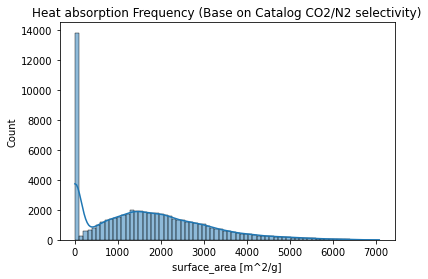

In [9]:
sns.histplot(data=df_train, x='surface_area [m^2/g]', kde=True)
plt.title('Heat absorption Frequency (Base on Catalog CO2/N2 selectivity)')
plt.show()

In [10]:
# surface_area = pickle.load(open("data/train/missing_surface_area.pkl", "rb"))
# # print(surface_area)
# for i in surface_area:
#     df_train.loc[i, 'surface_area [m^2/g]'] = surface_area[i]

## Encode

### Ordinal Encoder

In [11]:
encoder = {'functional_groups': function_groups_encoder}
df_train = df_train.replace(encoder)

### Hashing Encoder

In [12]:
topo_encoder = ce.HashingEncoder(cols='topology',n_components=10)
topo_encode = topo_encoder.fit_transform(df_train['topology'])
topo_name = list(topo_encode.columns)
topo_rename = {}

for i in range(len(topo_name)):
    topo_rename[topo_name[i]] = "topo_{}".format(i)

topo_encode = topo_encode.rename(columns = topo_rename)

df_train = df_train.drop('topology', axis=1)
df_train = pd.concat([topo_encode, df_train], axis=1)
pickle.dump(topo_encoder, open('model/hash_encode_topology.pkl', 'wb'))

In [13]:
# func_encoder = ce.HashingEncoder(cols='functional_groups',n_components=369)
# func_encode = func_encoder.fit_transform(df_train['functional_groups'])
# func_name = list(func_encode.columns)
# func_rename = {}

# for i in range(len(func_name)):
#     func_rename[func_name[i]] = "func_{}".format(i)

# func_encode = func_encode.rename(columns = func_rename)

# df_train = df_train.drop('functional_groups', axis=1)
# df_train = pd.concat([func_encode, df_train], axis=1)
# pickle.dump(encoder, open('model/hash_encode_functional.pkl', 'wb'))

In [14]:
print(df_train.columns)

Index(['topo_0', 'topo_1', 'topo_2', 'topo_3', 'topo_4', 'topo_5', 'topo_6',
       'topo_7', 'topo_8', 'topo_9', 'MOFname', 'volume [A^3]', 'weight [u]',
       'density [g/cm^3]', 'surface_area [m^2/g]', 'void_fraction',
       'void_volume [cm^3/g]', 'functional_groups', 'metal_linker',
       'organic_linker1', 'organic_linker2', 'catalog CO2/N2',
       'CO2/N2_selectivity', 'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]',
       'CO2_working_capacity [mL/g]'],
      dtype='object')


## Data Correlation

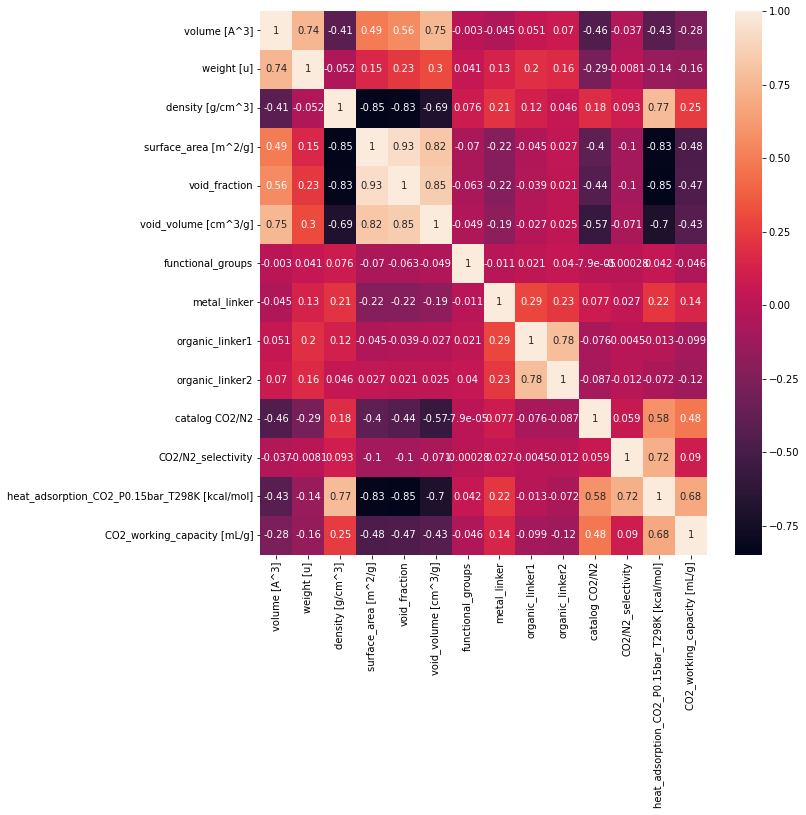

In [15]:
diagnosis_data = df_train.drop(labels=['MOFname'] + ['topo_{}'.format(i) for i in range(10)], axis=1)

plt.figure(figsize=(10, 10))
sns.heatmap(data=diagnosis_data.corr(), annot=True)
plt.show()

## Preprocessing Data

### Extract Features and Target and train_test_split

In [83]:
all_features = list(df_train.columns)
all_features.remove('MOFname')
all_features.remove('weight [u]')
all_features.remove('functional_groups')
all_features.remove('CO2_working_capacity [mL/g]')

features_idx = {}
for idx, feat in enumerate(all_features):
    features_idx[feat] = idx

print(features_idx)
json.dump(features_idx, open('model/general/features_idx.json', 'w'))
json.dump(all_features, open('model/general/features.json', 'w'))

{'topo_0': 0, 'topo_1': 1, 'topo_2': 2, 'topo_3': 3, 'topo_4': 4, 'topo_5': 5, 'topo_6': 6, 'topo_7': 7, 'topo_8': 8, 'topo_9': 9, 'volume [A^3]': 10, 'density [g/cm^3]': 11, 'surface_area [m^2/g]': 12, 'void_fraction': 13, 'void_volume [cm^3/g]': 14, 'metal_linker': 15, 'organic_linker1': 16, 'organic_linker2': 17, 'catalog CO2/N2': 18, 'CO2/N2_selectivity': 19, 'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]': 20}


In [84]:
features = ['void_volume [cm^3/g]', 'void_fraction', 'surface_area [m^2/g]']
target = ['CO2_working_capacity [mL/g]']

X, y = df_train[all_features].values, df_train[target].values
X = np.concatenate((X, latent_space, mol2vec_feat), axis=1) #, mol2vec_feat

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(check_nan_inf(X_train), check_nan_inf(X_test))

1351 581


### Target Encode Topology

In [85]:
# target_encoder_train_test(df_train, X_train, X_test, y_train, y_test, features_idx, 'functional_groups')

# X_train = X_train.astype(float)
# X_test = X_test.astype(float)
# print(X_train.shape, X_test.shape)

### Fill nan and inf (Heat adsorption)

In [86]:
clean_heat_adsorption_train_test(X_train, X_test, features_idx, num_catalog)

print(check_nan_inf(X_train), check_nan_inf(X_test))

0 0


In [87]:
# X_train = np.delete(X_train, features_idx['catalog CO2/N2'], 1)
# X_test = np.delete(X_test, features_idx['catalog CO2/N2'], 1)
# all_features.remove('catalog CO2/N2')

### Convert CO2/N2 selectivity by square root selectivity and multiply by heat adsorption

In [88]:
# X_train[:, features_idx['CO2/N2_selectivity']] = np.sqrt(X_train[:, features_idx['CO2/N2_selectivity']]) * X_train[:, features_idx['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]']]
# X_test[:, features_idx['CO2/N2_selectivity']] = np.sqrt(X_test[:, features_idx['CO2/N2_selectivity']]) * X_test[:, features_idx['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]']]

### Scale Data

In [89]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### DataLoader

In [90]:
class MOFDataSet(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [91]:
training_data = MOFDataSet(torch.tensor(X_train).to(device), torch.tensor(y_train).to(device))
test_data = MOFDataSet(torch.tensor(X_test).to(device), torch.tensor(y_test).to(device))

train_dataloader = DataLoader(training_data, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=True)

# Model

## MLP

### Tensorflow

In [60]:
def create_model(dim):
    input_ = Input(shape=(dim, ))
    x = Dense(64, activation='relu')(input_)
    x = Dropout(0.08)(x)
#     x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
#     x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
#     x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
#     x = BatchNormalization()(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=input_, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.004), loss='mean_absolute_error', metrics=['mean_absolute_error'])  
    return model

In [121]:
model = create_model(X_train.shape[1])

In [122]:
hist = model.fit(X_train, y_train, batch_size=256, epochs=200, validation_data=(X_test, y_test), verbose=0)

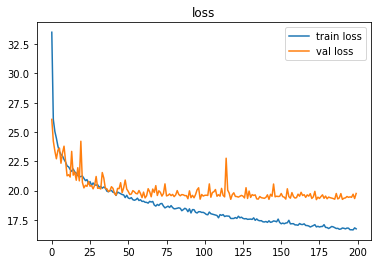

In [123]:
show_history(hist)

In [124]:
print("MAE: {}".format(hist.history['val_loss'][-1]))

MAE: 19.751649856567383


### Pytorch

In [103]:
class MLP(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU() 
        
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(128, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(256, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.01)
        
        self.output = nn.Linear(512, 1)
        
    def forward(self, x, batch_norm=False):
        x = self.fc1(x)
        if batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        if batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        if batch_norm:
            x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.fc4(x)
        if batch_norm:
            x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout(x)
        
        output = self.output(x)
        return output

In [104]:
def train(dataloader):
    model.train()
    c = 0
    correct = 0
    for batch, (X, y) in enumerate(dataloader):  # Iterate in batches over the training dataset.
        out = model(X.float())  # Perform a single forward pass.
        loss = criterion(out, y)  # Compute the loss.
        
        optimizer.zero_grad() # Clear gradients.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        c += 1
        correct += loss.cpu().detach().numpy()
        torch.cuda.empty_cache()
    return correct/c

def test(dataloader):
    model.eval()
    correct = 0
    c=0
    for batch, (X, y) in enumerate(dataloader):  # Iterate in batches over the training/test dataset.
        out = model(X.float())  
        loss = criterion(out, y)  # Compute the loss.
        correct += loss.cpu().detach().numpy()  # Check against ground-truth labels.
        c=c+1
        torch.cuda.empty_cache()
        loss.cpu().detach().numpy()
    return correct / c

In [105]:
model = MLP(X.shape[1], 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss()

train_loss = []
test_loss = []
epochs = 100
verbose = 0

for epoch in range(epochs):
    train_acc = train(train_dataloader)
    test_acc = test(test_dataloader)
    train_loss.append(train_acc)
    test_loss.append(test_acc)
    if verbose == 1:
        print(f'Epoch: {epoch+1:03d}, Train MAE: {train_acc:.4f}, Test MAE: {test_acc:.4f}')

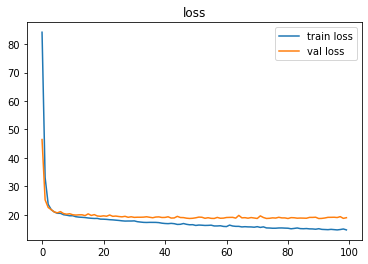

In [106]:
plt.title('loss')
plt.plot(np.arange(epochs), train_loss, label='train loss')
plt.plot(np.arange(epochs), test_loss, label='val loss')
plt.legend()
plt.show()

In [107]:
print("Train MAE: {}".format(train_loss[-1]))
print("Test MAE: {}".format(test_loss[-1]))

Train MAE: 14.648702134026422
Test MAE: 18.93847541809082


### Train all Data

In [108]:
clean_heat_adsorption(X, features_idx, 2)

sc = StandardScaler()
X = sc.fit_transform(X)
pickle.dump(sc, open('model/general/standardscaler.pkl', 'wb'))

dataset = MOFDataSet(torch.tensor(X).to(device), torch.tensor(y).to(device))
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [109]:
model = MLP(X.shape[1], 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss()

train_loss = []
epochs = 100
verbose = 0

for epoch in range(epochs):
    train_acc = train(dataloader)
    train_loss.append(train_acc)
    if verbose == 1:
        print(f'Epoch: {epoch+1:03d}, Train MAE: {train_acc:.4f}')

In [110]:
torch.save(model.state_dict(), "model/mlp.pt")

## XGBoost

In [27]:
n_estimators = 80 #Original 80
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=n_estimators)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_train)
mae = mean_absolute_error(y_train, preds)
print("train MAE: {}".format(mae))

preds = xg_reg.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print("val MAE: {}".format(mae))

train MAE: 16.87421392141149
val MAE: 20.49854403096886


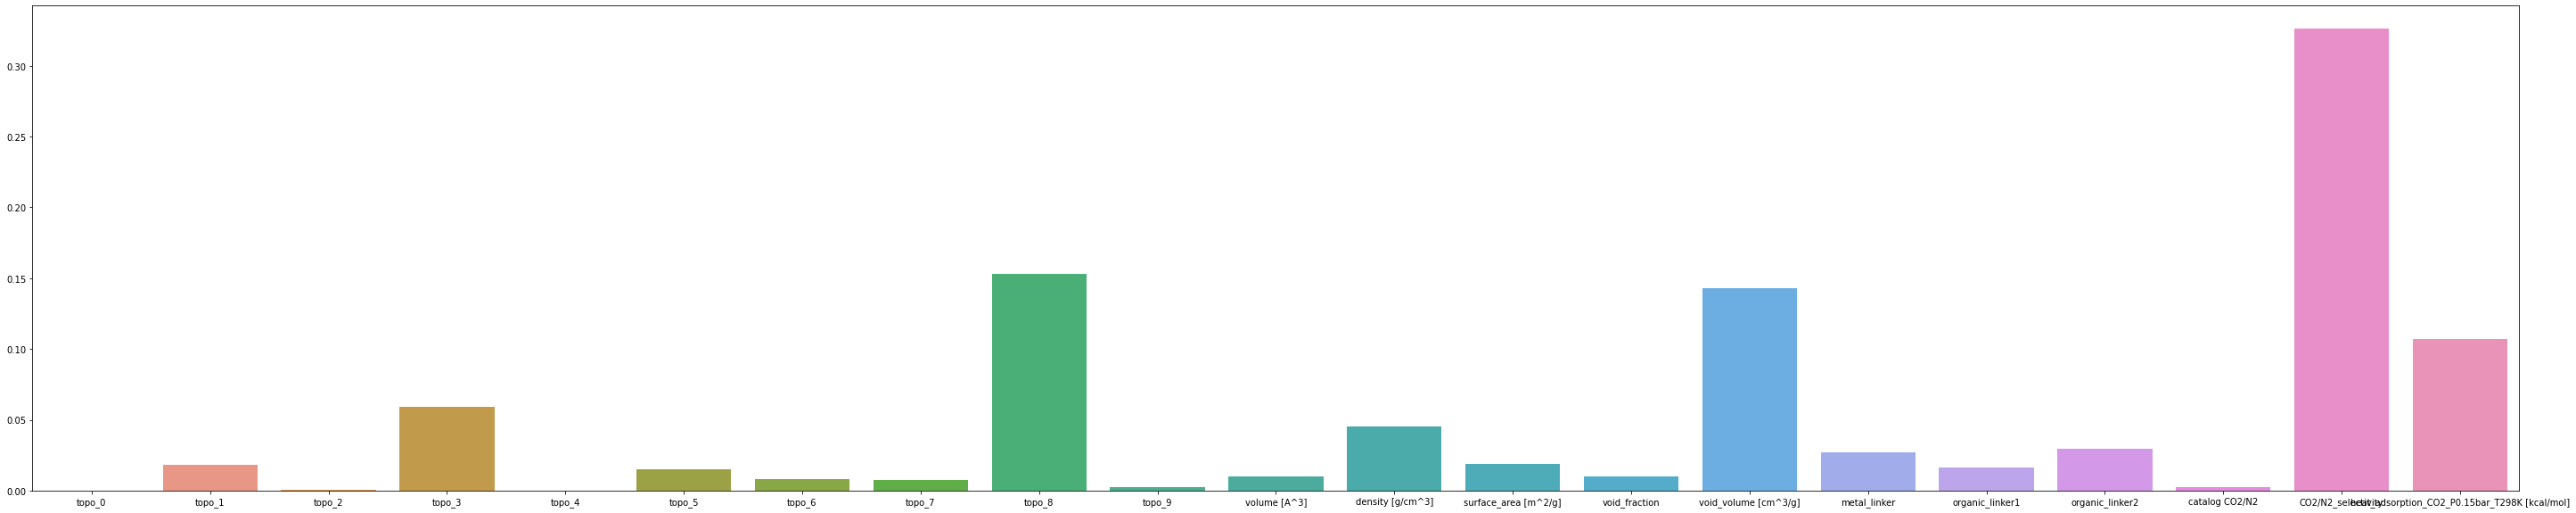

In [28]:
plt.figure(figsize=(50, 10))
sns.barplot(x=all_features, y=xg_reg.feature_importances_)
plt.show()

In [24]:
matric = []
fold_no = 1
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for train, test in kf.split(X, y):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    
    clean_heat_adsorption_train_test(X_train, X_test, features_idx, 2)
    
    xg_reg.fit(X_train, y_train)

    y_pred = xg_reg.predict(X_test)
    print('Fold No:', fold_no)
    print('MAE', round(mean_absolute_error(y_test, y_pred), 2))
    print()
    matric.append(mean_absolute_error(y_test, y_pred))
    fold_no += 1

print("Average MAE: {}".format(np.array(matric).mean()))

Fold No: 1
MAE 20.38

Fold No: 2
MAE 20.31

Fold No: 3
MAE 20.15

Fold No: 4
MAE 19.91

Fold No: 5
MAE 20.17

Average MAE: 20.183684701037286


###  Train all Data

In [29]:
clean_heat_adsorption(X, features_idx, 2)

sc = StandardScaler()
X = sc.fit_transform(X)
pickle.dump(sc, open('model/general/standardscaler.pkl', 'wb'))

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=n_estimators)
xg_reg.fit(X,y)
xg_reg.save_model('model/model.json')

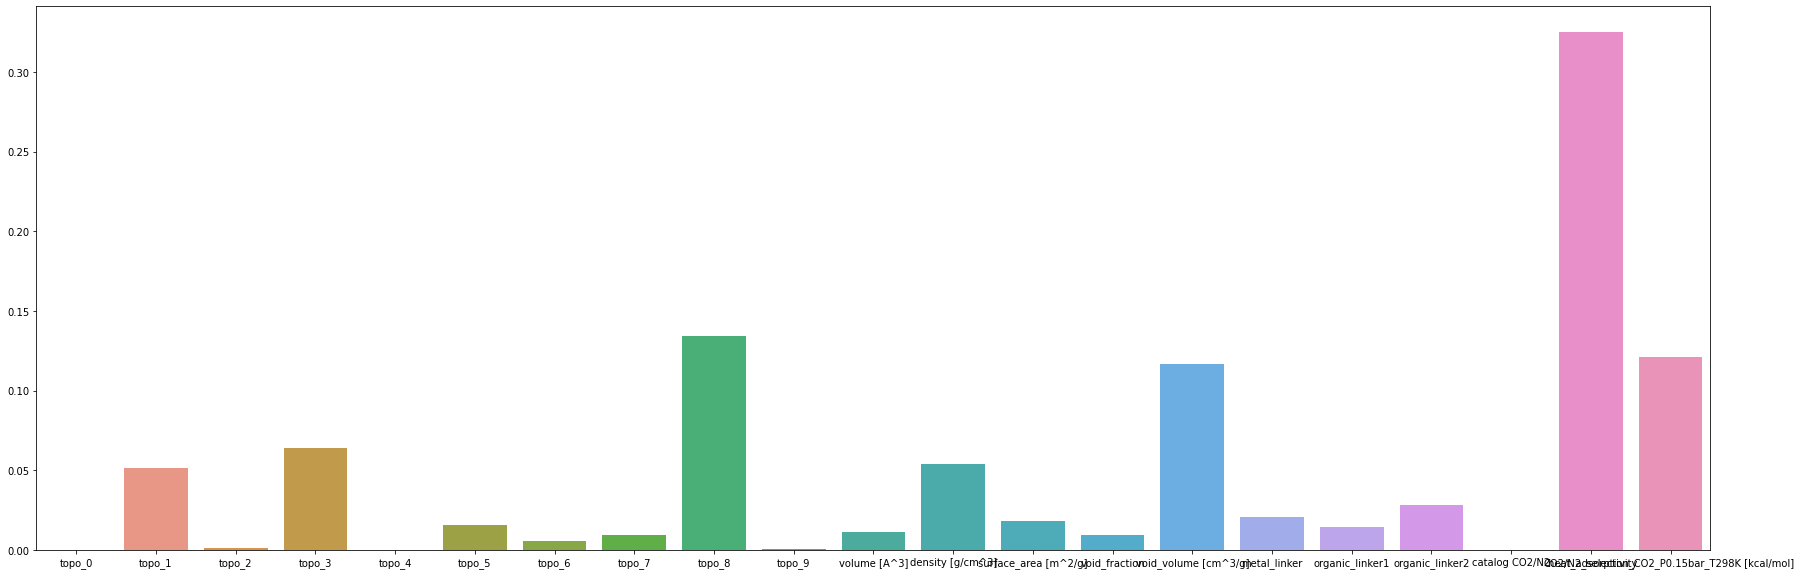

In [30]:
plt.figure(figsize=(30, 10))
sns.barplot(x=all_features, y=xg_reg.feature_importances_)
plt.show()